In [2]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
try:
    import empyrical as emp
except:
    emp = None
import tushare as ts
import time
import random
import itertools
# from concurrent.futures import ProcessPoolExecutor

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq
from spider.spider_coinmarketcap import Spider_coinmarketcap

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
CRYPTOCURRENCY = list(CRYPTOCURRENCY.keys())
NASDAQ100 = CONF['NASDAQ100']
HS300 = list(ts.get_hs300s()['code'])

BENCHMARK = '399300'
# TARGET = ['399300']
TARGET = HS300
# BENCHMARK = 'NDX'
# TARGET = NASDAQ100
# BENCHMARK = 'BITCOIN'
# TARGET = CRYPTOCURRENCY
# BENCHMARK = 'EOS'
# TARGET = ['EOS']

ALL_TARGET = TARGET[:]

pd

<module 'pandas' from 'd:\\python3\\lib\\site-packages\\pandas\\__init__.py'>

In [ ]:
%%time

IS_DOWNLOAD_DATA = False
spider_n = Spider_nasdaq()
spider_c = Spider_coinmarketcap()
timeframe = '10y'
ignore = True

for symbol in TARGET + [BENCHMARK]:
    if not IS_DOWNLOAD_DATA:
        break

    # 沪深300指数
    if symbol == '399300':
        df = ts.get_k_data(code=symbol, index=True, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        
    # A股
    elif symbol in HS300:
        df = ts.get_k_data(code=symbol, ktype='D', autype='qfq', index=False, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        
    # NASDAQ
    elif symbol in NASDAQ100:
        datafile = None
        while datafile is None:
            try:
                datafile = spider_n.get_stock_data(symbol, timeframe)
            except:
                time.sleep(5)
    
    # CRYPTOCURRENCY
    elif symbol in CRYPTOCURRENCY:
        datafile = spider_c.get_coin_data(symbol, start_date='20100101', end_date=time.strftime('%Y%m%d'))
        
    print(datafile)
    time.sleep(1)

In [15]:
%%time

### 时间设置
start_date = '2005-01-01'
end_date = '2018-08-01'

TURTLE_POS = 50
### Turtle System One - Short
TURTLE_SHORT_BUY_N = 20
TURTLE_SHORT_SELL_N = 20
### Turtle System Two - Long
TURTLE_LONG_BUY_N = 60
TURTLE_LONG_SELL_N = 60

### 业务设置
IS_HAPPYMONEY = False
IS_TAX = False
IS_SLIPPAGE = False
IS_RANDOM_BUY = False
IS_FILTER = False
IS_MARKETUP = True
IS_BUYBENCHMARK = True
IS_SHOWBUYLIST = True
START_MONEY = 100000
HAPPY_MONEY = 0
PROPERTY = START_MONEY
CASH = START_MONEY


Wall time: 0 ns


In [16]:
%%time

def get_stock_df_dict(TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N):
    stock_df_dict = {}
    for symbol in TARGET + [BENCHMARK]:
        stock_data_file = '../database/market/%s.csv' % symbol
        stock_df = pd.read_csv(stock_data_file)

        # 筛选字段
        stock_df = stock_df.loc[:, ['date', 'open', 'close']]

        # 去掉Nasdaq行情首行的当天行情
        if symbol in NASDAQ100:
            stock_df = stock_df.drop([0])

        # 抛弃空值异常值
        stock_df.dropna(axis=0, how='any', inplace=True)

        # 格式化日期
        stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

        # 用日期作索引，日期升序排序
        if symbol in NASDAQ100 or symbol in CRYPTOCURRENCY:
            stock_df = stock_df[::-1]
        stock_df.set_index(['date'], inplace=True)
        stock_df.index = stock_df.index.to_period('D')

        # 计算每天涨跌幅
        stock_df['o_pct_chg'] = stock_df.open.pct_change(1)
        stock_df['c_o_pct_chg'] = (stock_df.open - stock_df.close.shift(1)) / stock_df.close.shift(1)

        # Turtle指标
        stock_df['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N] = stock_df['open'].rolling(TURTLE_LONG_BUY_N).max()
        stock_df['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N] = stock_df['open'].rolling(TURTLE_LONG_SELL_N).min()
        stock_df['MA180'] = stock_df['open'].rolling(180).mean()
        stock_df['MA60'] = stock_df['open'].rolling(60).mean()
        stock_df['MA30'] = stock_df['open'].rolling(30).mean()

        # 减少数据
        stock_df.dropna(how='any', inplace=True)

        stock_df_dict[symbol] = stock_df
        
    return stock_df_dict

Wall time: 500 µs


In [17]:
%%time
# %xmode

def run_turtle(symbol_list, stock_df_dict, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N):
    PROPERTY = START_MONEY
    CASH = START_MONEY
    count_day = 0
    yesterday = None
    miss_buy_short = 0
    miss_buy_long = 0
    
    '''用基准数据来存储策略数据'''
    show_df = None
    show_df = stock_df_dict[BENCHMARK].copy()
    show_df.loc[:, 'CASH_TURTLE'] = START_MONEY
    show_df.loc[:, 'PROPERTY_TURTLE'] = START_MONEY

    order_df = None
    order_df = pd.DataFrame(columns=[
        'buy_date', 'symbol', 'buy_count', 'buy_price', 'buy_reason', 'sell_date', 'sell_price', 'sell_reason', 'profit', 'cash', 'property'
    ])

    ops_df = None
    ops_df = pd.DataFrame(columns=[
        'ops_date', 'ops', 'symbol', 'count', 'price', 'reason', 'profit'
    ])


    # 时间序列
    for today in pd.period_range(start=start_date, end=end_date, freq='D'):
        count_day += 1

        # 每年年初计算回报率
        if today.dayofyear == 1 or today == (pd.to_datetime(end_date)).to_period(freq='D'):
            print(today, time.ctime())
    #         if today.dayofyear == 1:
    #             lastyear_firstday = pd.to_datetime('%d-01-01' % (today.year - 1))
    #         else:
    #             lastyear_firstday = pd.to_datetime('%d-01-01' % today.year)
    #         lastyear_firstday = lastyear_firstday.to_period(freq='D')
    # #         print(today, show_df.iloc[0].name, show_df[:today].iloc[-1].PROPERTY_TURTLE)
    #         if today > show_df.iloc[0].name:
    #             today_property = show_df[:today].iloc[-2].PROPERTY_TURTLE
    # #             print(show_df[:today].iloc[-1])
    #         else:
    #             today_property = show_df.iloc[0].PROPERTY_TURTLE
    #         if lastyear_firstday > show_df.iloc[0].name:
    #             lastyear_firstday_property = show_df[:lastyear_firstday].iloc[-1].PROPERTY_TURTLE
    #         else:
    #             lastyear_firstday_property = show_df.iloc[0].PROPERTY_TURTLE
    # #         lastyear_return = round((today_property - lastyear_firstday_property) / lastyear_firstday_property, 4)
    #         lastyear_return = '%.3f' % ((today_property - lastyear_firstday_property) / lastyear_firstday_property)
    #         print(lastyear_firstday, today, int(lastyear_firstday_property), int(today_property), lastyear_return)
    
        # 每年筛股
        if IS_FILTER and (today.dayofyear == 1 or count_day == 1):
            TARGET = ALL_TARGET[:]
            benchmark_lastyear = stock_df_dict[BENCHMARK][:today]

            # 不到一年（250个交易日）
            if len(benchmark_lastyear) < 250:
                continue

            # 筛选过滤
            benchmark_return_lastyear = benchmark_lastyear.iloc[-1].open / benchmark_lastyear.iloc[-250].open
            for symbol, stock_df in stock_df_dict.items():
                try:
                    return_lastyear = stock_df[:today].iloc[-1].open / stock_df[:today].iloc[-250].open
                    if return_lastyear < benchmark_return_lastyear:
                        TARGET.remove(symbol)
    #                     print(symbol, return_lastyear)
                except:
                    TARGET.remove(symbol)
                    pass
            print(today, 'TARGET after filter', len(TARGET))


        if yesterday is None:
            yesterday = today
            continue

        # 日期不在基准交易日，则不交易
        if today not in stock_df_dict[BENCHMARK].index:
            continue

        # 突破下行趋势，清仓退出
        order_arr = order_df.to_records(index=False)
        if len(order_arr[(order_arr.buy_count > 0) & (order_arr.sell_price == 0)] ) != 0:
            is_sell = False
            for idx in order_df[(order_df['buy_count'] > 0) & (order_df['sell_price'] == 0)].index:
                cur_order = order_df.loc[idx]
                symbol = cur_order['symbol']
                if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
                    continue
                today_market = stock_df_dict[symbol].loc[today]
                if today_market.c_o_pct_chg < -0.1 and symbol in HS300:
    #                 print(today, symbol, '跌停板，卖不掉')
                    continue
                if cur_order.buy_reason == 'SHORT':
                    is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N])
                if cur_order.buy_reason == 'LONG':
                    is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N])
                if is_sell:
                    CASH += cur_order.buy_count * today_market.open
                    order_df.loc[idx, 'sell_date'] = today
                    order_df.loc[idx, 'sell_price'] = today_market.open
                    order_df.loc[idx, 'sell_reason'] = 'EXIT'
                    order_df.loc[idx, 'profit'] = \
                        (today_market.open - cur_order.buy_price) * cur_order.buy_count
    #                 print(today, '退出', stock_df_dict[symbol].loc[today, 'open'], CASH)

                    ops_df = ops_df.append(
                        {
                            'ops_date': today,
                            'ops': 'SELL',
                            'symbol': symbol,
                            'count': cur_order.buy_count,
                            'price': today_market.open,
                            'reason': cur_order.buy_reason,
                            'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
                        },
                        ignore_index=True
                    )

        # 开心止盈，倍数止盈
        if IS_HAPPYMONEY:        
            if PROPERTY > START_MONEY * 2 and CASH > START_MONEY:
                HAPPY_MONEY += START_MONEY
                PROPERTY -= START_MONEY
                CASH -= START_MONEY

        benchmark_today_market = stock_df_dict[BENCHMARK].loc[today]
        try:
            benchmark_yesterday_market = stock_df_dict[BENCHMARK].loc[:today].iloc[-2]
        except:
            benchmark_yesterday_market = stock_df_dict[BENCHMARK].loc[:today].iloc[-1]
        buy_list = []

        # 遍历标的，判断和执行买入
        for symbol in symbol_list:

            # 趋势交易，只在好行情时买入
            if IS_MARKETUP:
                if benchmark_today_market.MA60 < benchmark_today_market.MA180:
    #             if benchmark_yesterday_market.MA60 < benchmark_yesterday_market.MA180:
                    break

            # 是否购买基准
            if not IS_BUYBENCHMARK and symbol == BENCHMARK:
                continue

            if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
                continue

            # TIME TEST
            # DELETED

            today_market = stock_df_dict[symbol].loc[today]

            # 突破上行趋势，就买一份
            order_arr = order_df.to_records(index=False)
            is_buy = False
            # 指数就不要过滤器了
            if True:
                if today_market.open >= today_market['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N]:
                    is_buy = True
                    buy_reason = 'LONG'
                elif False and today_market.open >= today_market['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N]:
                    is_buy = True
                    buy_reason = 'SHORT'

            if is_buy:
                buy_list.append(symbol)

        if IS_RANDOM_BUY:
            random.shuffle(buy_list)
        else:
            tmp_list = []
            for symbol in buy_list:
                try:
                    return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[-250].open
                except:
                    return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[1].open
                tmp_list.append((return_lastyear, symbol))
            tmp_list = sorted(tmp_list, reverse=True)
            buy_list = [x[1] for x in tmp_list if x[0]>1]
    #         buy_list = [x[1] for x in tmp_list]

        for symbol in buy_list:
            today_market = stock_df_dict[symbol].loc[today]
            buy_count = 0

            # 滑点
            if IS_SLIPPAGE:
                buy_price = today_market.open * (1 + random.randint(0, 20) / 1000)
            else:
                buy_price = today_market.open

            # 按份数买
            if CASH >= PROPERTY / TURTLE_POS:
                buy_count = int((PROPERTY / TURTLE_POS) / buy_price)

            # 指数购买，满仓干
    #         buy_count = int(CASH / buy_price)

            if buy_count > 0:
                if today_market.c_o_pct_chg > 0.1 and symbol in HS300:
    #                 print(today, symbol, '涨停板，买不进')
                    continue

            if buy_count > 0:
                CASH -= buy_count * buy_price
    #             print(today, '建仓', buy_count, stock_df_dict[symbol].loc[today, 'open'], CASH)
                order_df = order_df.append(
                    {
                        'buy_date': today,
                        'symbol': symbol,
                        'buy_count': buy_count,
                        'buy_price': today_market.open,
                        'buy_reason': buy_reason,
                        'sell_date': pd.np.nan,
                        'sell_price': 0,
                        'profit': 0,
                        'cash': CASH,
                        'property': PROPERTY,
                    },
                    ignore_index=True
                )
                ops_df = ops_df.append(
                    {
                        'ops_date': today,
                        'ops': 'BUY',
                        'symbol': symbol,
                        'count': buy_count,
                        'price': buy_price,
                        'reason': buy_reason,
                        'profit': 0,
                    },
                    ignore_index=True
                )
            else:
                if buy_reason == 'LONG':
                    miss_buy_long += 1
                elif buy_reason == 'SHORT':
                    miss_buy_short += 1

        # 每天盘点财产
        # 大盘下行时，闲钱进行T+0无风险投资，如货币基金
        if benchmark_today_market.MA60 < benchmark_today_market.MA180:
            CASH = CASH * (1 + 0.03 / 365)
        show_df.loc[today, 'CASH_TURTLE'] = CASH
        PROPERTY = CASH + \
            sum(
                [
                    stock_df_dict[order_df.loc[idx, 'symbol']][:today].iloc[-1].open * order_df.loc[idx, 'buy_count'] \
                    for idx in order_df.loc[order_df['sell_price']==0].index
                ]
            )
        show_df.loc[today, 'PROPERTY_TURTLE'] = PROPERTY

        yesterday = today



    # 最后一天，清仓
    order_arr = order_df.to_records(index=False)
    for idx in order_df[order_df['sell_price'] == 0].index:
        cur_order = order_df.loc[idx]
        symbol = cur_order['symbol']
        today_market = stock_df_dict[symbol][:today].iloc[-1]
        CASH += cur_order.buy_count * today_market.open
        order_df.loc[idx, 'sell_date'] = today
        order_df.loc[idx, 'sell_price'] = today_market.open
        order_df.loc[idx, 'sell_reason'] = 'EXIT'
        order_df.loc[idx, 'profit'] = \
            (today_market.open - cur_order.buy_price) * cur_order.buy_count
        ops_df = ops_df.append(
            {
                'ops_date': today,
                'ops': 'SELL',
                'symbol': symbol,
                'count': cur_order.buy_count,
                'price': today_market.open,
                'reason': cur_order.buy_reason,
                'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
            },
            ignore_index=True
        )


#     print('START_MONEY', START_MONEY)
#     print('CASH', CASH)
#     print('HAPPY_MONEY', HAPPY_MONEY)
#     print('PROPERTY', PROPERTY)

#     s_p = stock_df_dict[BENCHMARK][start_date:].iloc[0].open
#     e_p = stock_df_dict[BENCHMARK][:end_date].iloc[-1].open
#     print('BENCHMARK', s_p, e_p, e_p / s_p)
    return show_df, order_df, PROPERTY, miss_buy_long


Wall time: 0 ns


In [18]:
score_df = None
score_df = pd.DataFrame(columns=[
    'START',
    'END',
    'TURTLE_POS',
    'ROLLMAX',
    'ROLLMIN', 
    'MA_SHORT', 
    'MA_LONG', 
    'X_DAY_RETURN', 
    'ORDER',
    'STOCK',
    'RETURN',
    'MAXDROPDOWN',
    'WINRATE',
    'annual_return',
    'annual_volatility',
    'calmar_ratio',
    'sharpe_ratio',
    'alpha',
    'beta',
    'ALL_DAYS',
    'FREECASH_DAY',
    'MISS_SIGNAL',
    'RET_PER_YEAR',
])

In [30]:
TURTLE_POS = 40
TURTLE_LONG_BUY_N = 60
TURTLE_LONG_SELL_N = 60

# for i in range(6, 19, 1):
# for i in range(11, 14, 1):
# for i in range(15, 81, 1):
    time.ctime()
    print(i)
    global TURTLE_POS
    TURTLE_POS = i
#     TURTLE_LONG_BUY_N = i
#     TURTLE_LONG_SELL_N = i

    stock_df_dict = None
    show_df = None
    order_df = None
    PROPERTY = None
    symbol_list = TARGET + [BENCHMARK]

    stock_df_dict = get_stock_df_dict(TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)
    show_df, order_df, PROPERTY, miss_buy_long = run_turtle(symbol_list, stock_df_dict, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)

    df = show_df.dropna(how='any', inplace=False).copy()
    df = df.loc[start_date:end_date]
    algo = df['PROPERTY_TURTLE'].pct_change()
    benchmark = df.open.pct_change()

#     if emp:
#         'cum_returns', emp.cum_returns(algo)[-1], emp.cum_returns(benchmark)[-1]
#         'max_drawdown', emp.max_drawdown(algo), emp.max_drawdown(benchmark)
#         'annual_return', emp.annual_return(algo), emp.annual_return(benchmark)
#         'annual_volatility', emp.annual_volatility(algo, period='daily')
#         'calmar_ratio', emp.calmar_ratio(algo)
#         'sharpe_ratio', emp.sharpe_ratio(returns=algo)
#         'alpha', emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00)
#         'beta', emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00)

    ALL_DAYS = len(df)
    FREECASH_DAY = len(df[df['CASH_TURTLE'] > (df['PROPERTY_TURTLE'] / TURTLE_POS)])


    output_str = ''
    for y in range(int(start_date.split('-')[0]), int(end_date.split('-')[0])+1, 1):
        y_df = df.loc['%d-01-01' % y:'%d-01-01' % (y+1)]
        y_algo = y_df['PROPERTY_TURTLE'].pct_change()
        y_benchmark = y_df.open.pct_change()
        result = '%d-%d,%.3f,%.3f,%.3f,%.3f' % (
            y, y+1, emp.cum_returns(y_algo)[-1], emp.cum_returns(y_benchmark)[-1], emp.max_drawdown(y_algo), emp.max_drawdown(y_benchmark)
        )
#         result
        output_str += result
        output_str += ';'
#     output_str

    df = order_df.copy()
    df['pro_pct'] = (df.sell_price - df.buy_price) / df.buy_price
    df = df.loc[:, ['symbol', 'pro_pct']]
    df = df.groupby(by='symbol').sum()
    buy_stock_count = len(df)
#     buy_stock_count
    
    score_df = score_df.append({
        'START': start_date,
        'END': end_date,
        'TURTLE_POS': TURTLE_POS,
        'ROLLMAX': TURTLE_LONG_BUY_N,
        'ROLLMIN': TURTLE_LONG_SELL_N, 
        'MA_SHORT': 60, 
        'MA_LONG': 180, 
        'X_DAY_RETURN': 250, 
        'ORDER': len(order_df),
        'STOCK': buy_stock_count,
        'RETURN': emp.cum_returns(algo)[-1],
        'MAXDROPDOWN': emp.max_drawdown(algo),
        'WINRATE': len(order_df[order_df.profit > 0]) / len(order_df[order_df.profit != 0]),
        'annual_return': emp.annual_return(algo),
        'annual_volatility': emp.annual_volatility(algo, period='daily'),
        'calmar_ratio': emp.calmar_ratio(algo),
        'sharpe_ratio': emp.sharpe_ratio(returns=algo),
        'alpha': emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00),
        'beta': emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00),
        'ALL_DAYS': ALL_DAYS,
        'FREECASH_DAY': FREECASH_DAY,
        'MISS_SIGNAL': miss_buy_long,
        'RET_PER_YEAR': output_str,
    }, ignore_index = True)

score_df
score_df.to_csv('../database/%s.csv' % time.strftime('%Y-%m-%d-%H-%M-%S'))

IndentationError: unexpected indent (<ipython-input-30-c2bd2256a4f8>, line 8)

0.30922439807498625

0.25191044054265477

,TURTLE_POS,ROLLMAX,RETURN,MAXDROPDOWN,STOCK,ORDER,annual_volatility,FREECASH_DAY,alpha,beta
0,5,60,44.547872,-0.483994,55,68,0.330530,1107,0.287071,0.516862
1,6,60,89.101910,-0.443705,62,81,0.348470,1151,0.346278,0.534098
2,7,60,33.294630,-0.468906,78,104,0.325015,1212,0.257055,0.546405
3,8,60,71.742568,-0.463546,80,110,0.323970,1212,0.319700,0.540767
4,9,60,65.936052,-0.477730,87,127,0.328843,1217,0.311218,0.561501
5,10,60,74.114352,-0.491950,92,142,0.335272,1229,0.324077,0.553273
6,11,60,53.232972,-0.462916,101,158,0.318100,1221,0.293061,0.544837
7,12,60,66.173834,-0.501394,105,171,0.315027,1227,0.307750,0.557810
8,13,60,56.097697,-0.467242,111,183,0.311128,1284,0.291824,0.566314
9,14,60,57.743801,-0.462370,116,199,0.308181,1288,0.293205,0.566572


d:\python3\lib\site-packages\pandas\plotting\_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


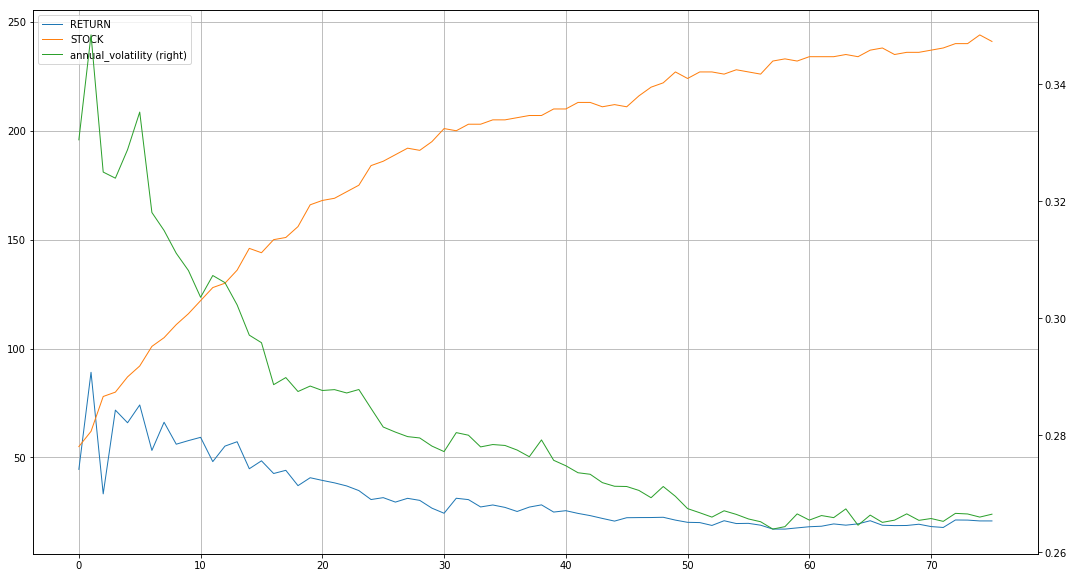

In [39]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
plt.rcParams['figure.figsize'] = [18, 10]

# df = pd.read_csv('../database/2018-09-10-00-18-21.csv')
df = score_df.copy()
df.drop(columns=['MA_SHORT', 'MA_LONG', 'X_DAY_RETURN'], inplace=True)
df = df.loc[:, ['TURTLE_POS', 'ROLLMAX', 'RETURN', 'MAXDROPDOWN', 'STOCK', 'ORDER', 'annual_volatility', 'FREECASH_DAY', 'alpha', 'beta']]
# df.set_index(keys='TURTLE_POS', inplace=True)
# df.sort_values(by='RETURN', ascending=False)
# df

# df = df.groupby(by=['TURTLE_POS', 'ROLLMAX']).count()
# df.groupby(by=['ROLLMAX']).count()
# df = df.groupby(by='ROLLMAX').mean()

# df.groupby(by=['TURTLE_POS']).count()
# df = df.groupby(by='TURTLE_POS').mean()

emp.annual_volatility(benchmark, period='daily')
emp.annual_volatility(benchmark[:250], period='daily')

df
ax = df.plot(kind='line', y=['RETURN', 'STOCK'], label='RETURN', linewidth=1, grid=True)
ax = df.plot(kind='line', y=['annual_volatility'], secondary_y=True, linewidth=1, grid=True, ax=ax)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.bar(left='ROLLMAX', height='TURTLE_POS', zs='RETURN', zdir='TURTLE_POS', alpha=0.8)
# ax.bar(left=df['ROLLMAX'], height=df['TURTLE_POS'], zs=df['RETURN'], zdir=df['TURTLE_POS'], alpha=0.8)

# X = np.arange(-5, 5, 0.25)
# Y = np.arange(-5, 5, 0.25)
# X, Y = np.meshgrid(X, Y)
# X
# Y
# x = df.columns
# x = np.arange(len(df.columns))
# x
# y = df.index
# y
# X,Y = np.meshgrid(x,y)
# Z = df
# Z
# ax.plot_surface(X, Y, Z)
# ax.bar(left=x, height=y, zs=Z, zdir=Z, alpha=0.8)